<a href="https://colab.research.google.com/github/arnisafazla/CS490/blob/main/CS_490_notes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd /content/drive/MyDrive/CS490/CS490-Senior-Research-Project

/content/drive/MyDrive/CS490/CS490-Senior-Research-Project


In [ ]:
! git pull

Already up to date.


In [ ]:
!git config --global user.email "arnisa.fazla@ug.bilkent.edu.tr"
!git config --global user.name "arnisafazla"
! git add .

In [ ]:
! git commit -m 'changing batch normalizationto instance normalization in critic ca'

[main 8f69afe] clean up. spatially adaptive normalization next
 13 files changed, 1 insertion(+), 19955 deletions(-)
 delete mode 100644 490_main.ipynb
 delete mode 100644 CS490_download_datasets.ipynb
 delete mode 100644 CS_490_main.ipynb
 delete mode 100644 CS_490_main_WGAN.ipynb
 delete mode 100644 CS_490_main_generation.ipynb
 delete mode 100644 CS_490_main_generation_GAN.ipynb
 delete mode 100644 CS_490_main_vanilla_GAN.ipynb
 delete mode 100644 CS_490_notes.ipynb
 delete mode 100644 conv_model.ipynb
 delete mode 100644 model.png
 delete mode 100644 models/Simple_LSTM_WGAN.py
 delete mode 100644 projection_critic.py
 rewrite setup.ipynb (95%)


In [ ]:
! git check-ignore -v __pycache__/

.gitignore:1:__pycache__	__pycache__/


In [ ]:
! echo 'models/__pycache__/*' >> .gitignore

In [ ]:
! git add models/
! git add tools.py

In [ ]:
! git push origin main

Counting objects: 4, done.
Delta compression using up to 2 threads.
Compressing objects: 100% (4/4), done.
Writing objects: 100% (4/4), 847 bytes | 282.00 KiB/s, done.
Total 4 (delta 3), reused 0 (delta 0)
remote: Resolving deltas: 100% (3/3), completed with 3 local objects.
To https://github.com/arnisafazla/CS490-Senior-Research-Project.git
   2620f42..8f69afe  main -> main


In [3]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from keras.utils.vis_utils import plot_model

# path to the cloned repo
main_dir = '/content/drive/MyDrive/CS490/CS490-Senior-Research-Project'  
# path to the dataset folder
dataset_dir = '/content/drive/MyDrive/CS490/dataset'
%cd {main_dir}
sys.path.insert(0,main_dir)
sys.path.insert(0,'/content/drive/MyDrive/CS490')
from dataset import Dataset
from models.critic_models.LSTM_critic import define_critic
from models.critic_models.projection_critic import define_projection_critic
from models.generator_models.LSTM_generator import define_generator
from models.Base_WGAN import Base_WGAN

/content/drive/MyDrive/CS490/CS490-Senior-Research-Project


In [3]:
# %cd ..
# !mkdir generator_models
%cd models/generator_models
! touch norm_generator.py

/content/drive/MyDrive/CS490/CS490-Senior-Research-Project/models/generator_models


In [4]:
# path is the path to the dataset
dataset = Dataset(["anger", "joy", "fear", "neutral", "sadness", "pride"], path=dataset_dir, step_size=10, frames=200)
# dataset = Dataset(["anger"], path=dataset_dir, step_size=10, frames=400)

anger


100%|██████████| 65/65 [00:22<00:00,  2.92it/s]


joy


100%|██████████| 29/29 [00:06<00:00,  4.80it/s]


fear


100%|██████████| 32/32 [00:06<00:00,  4.77it/s]


neutral


100%|██████████| 84/84 [00:14<00:00,  5.87it/s]


sadness


100%|██████████| 46/46 [00:08<00:00,  5.12it/s]


pride


100%|██████████| 24/24 [00:05<00:00,  4.61it/s]


In [5]:
Dataset.balance(dataset)

No. of samples in each class will be:  1114


In [6]:
# save this as a separate file
config = {       # change hyperparams here
        'latent_dim' : 400,
        'in_shape' : (dataset.frames, 69),
        'n_classes' :  dataset.emotions.shape[0],
        'init_std' : 0.01,
        'epochs' : 20,
        'batch_size' : 128,
        'n_critic' : 3,
        'dataset_balanced' : True,
        'critic_batch_norm' : False,
        'critic_instance_norm' : True,
        'critic_dropout' : 0,
        'gp_weight' : 10.0      # for the gradient penalty used in critic
      }

In [7]:
critic = define_projection_critic(config)
# plot_model(critic, show_shapes=True, show_layer_names=True)
generator = define_generator(config)
# plot_model(generator, show_shapes=True, show_layer_names=True)

In [11]:
outputs_path = '/content/drive/MyDrive/CS490/models'
# the saved models, outputs, adn config files will go to this path
gan = Base_WGAN(config, dataset, outputs_path, 'WGAN_projection_instance_norm_', critic, generator)

In [12]:
generator_optimizer = keras.optimizers.Adam(
    learning_rate=0.0002, beta_1=0.5, beta_2=0.9
)
critic_optimizer = keras.optimizers.Adam(
    learning_rate=0.0002, beta_1=0.5, beta_2=0.9
)
# Define the loss functions for the critic,
# which should be (fake_loss - real_loss).
# We will add the gradient penalty later to this loss function.
def critic_loss(real, fake):
    real_loss = tf.reduce_mean(real)
    fake_loss = tf.reduce_mean(fake)
    return fake_loss - real_loss
# Define the loss functions for the generator.
def generator_loss(fake):
    return -tf.reduce_mean(fake)

# gan = Base_WGAN('/content/drive/MyDrive/CS490/models', 'WGAN', None, critic, generator, config, dataset)

# Compile the WGAN model.
gan.compile(
    c_optimizer=critic_optimizer,
    g_optimizer=generator_optimizer,
    g_loss_fn=generator_loss,
    c_loss_fn=critic_loss,
)

# Start training the model.
# wgan.fit(train_images, batch_size=BATCH_SIZE, epochs=epochs, callbacks=[cbk])

In [10]:
# load model
model_path = '/content/drive/MyDrive/CS490/models/WGAN_projection2022.01.27-14:14:48/epoch_2'
outputs_path = '/content/drive/MyDrive/CS490/models'
gan = Base_WGAN(dest_dir=outputs_path, name=None, model_load=model_path, critic=None, generator=None)

TypeError: ignored

In [13]:
logs_path = '/content/drive/MyDrive/CS490/logs' # path to the tensorboard logs
gan.train(logs_path)

>1, 1/52, c_loss=nan, g_loss=nan
>1, 2/52, c_loss=nan, g_loss=nan
>1, 3/52, c_loss=nan, g_loss=nan
>1, 4/52, c_loss=nan, g_loss=nan


KeyboardInterrupt: ignored

In [14]:
gan.critic.summary()

Model: "critic"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 sequence_input (InputLayer)    [(None, 200, 69)]    0           []                               
                                                                                                  
 lstm1 (LSTM)                   (None, 200, 69)      38364       ['sequence_input[0][0]']         
                                                                                                  
 instance_normalization (Instan  (None, 200, 69)     138         ['lstm1[0][0]']                  
 ceNormalization)                                                                                 
                                                                                                  
 lstm2 (LSTM)                   (None, 69)           38364       ['instance_normalization[0][

In [ ]:
for dir in os.listdir('/content/drive/MyDrive/CS490/models'):
  if dir[0:4] == 'WGAN' and dir != 'WGAN2022.01.26-14:29:43':
    path = os.path.join('/content/drive/MyDrive/CS490/models', dir)
    ! rm -rf $path

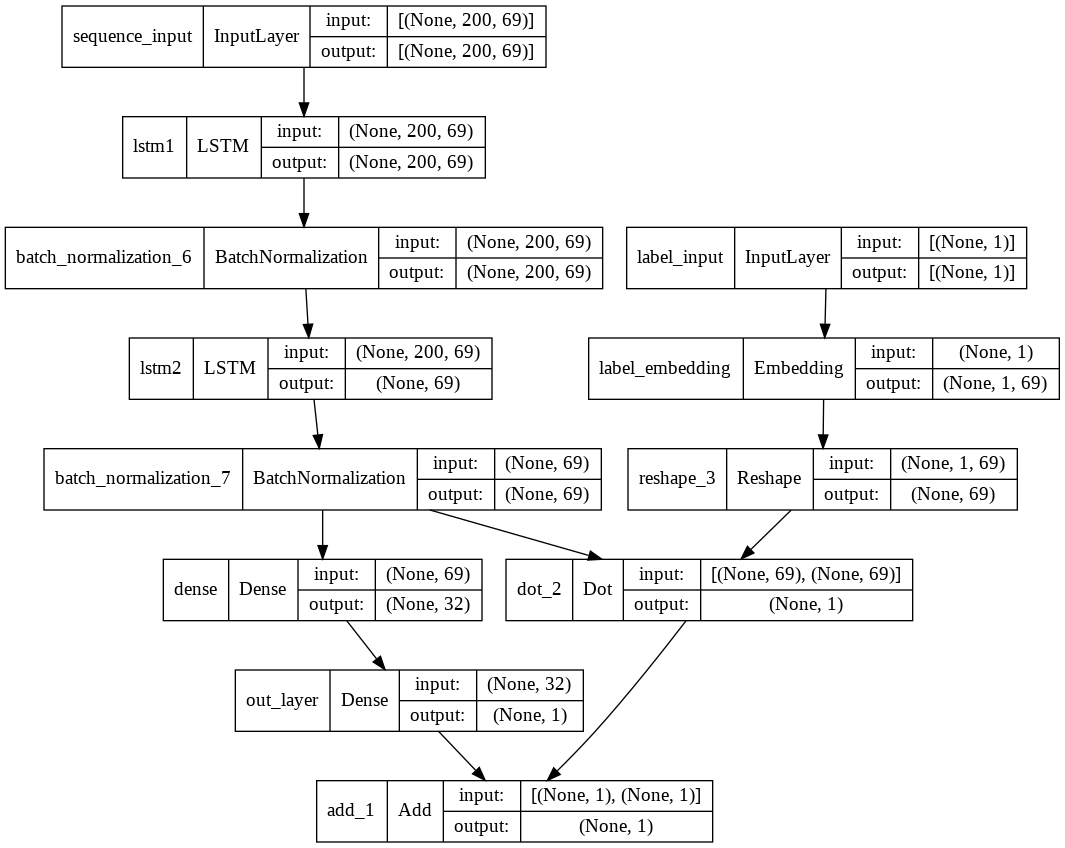

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(critic, show_shapes=True, show_layer_names=True)


In [ ]:
! rm -rf /content/drive/MyDrive/CS490/models/WGAN2022.01.27-14:10:21

In [6]:
! pip install tensorflow_addons

     |████████████████████████████████| 1.1 MB 5.0 MB/s 


In [8]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import utils
import tensorflow_addons as tfa
  
def define_generator(config):
  init = keras.initializers.RandomNormal(stddev=config['init_std'])
  in_label = layers.Input(shape=(1,), name='label_input')
  li = layers.Embedding(config['n_classes'], config['in_shape'][1], name='label_embedding')(in_label)
  li = layers.Reshape((-1,))(li)
  li = layers.RepeatVector(config['in_shape'][0], name='label_repeat')(li)

  in_lat = layers.Input(shape=(config['latent_dim'],), name='seq_input')
  lat = layers.Dense(config['in_shape'][0] * config['in_shape'][1], name='lat_upsample')(in_lat)
  lat = layers.Reshape((config['in_shape'][0], config['in_shape'][1]))(lat)
  # merge = keras.layers.Concatenate(name='concatenate', axis=2)([li, lat])

  hidden1 = layers.LSTM(config['in_shape'][1], name='hidden1', return_sequences=True, kernel_initializer=init)(lat)
  hidden1 = tfa.layers.InstanceNormalization()(hidden1)
  out_layer = layers.LSTM(config['in_shape'][1], name='out_LSTM', return_sequences=True, kernel_initializer=init)(hidden1)
 
  model = keras.Model([in_label, in_lat], out_layer, name='generator')
  return model

In [12]:
generator = define_generator(config)

In [13]:
generator.summary()

Model: "generator"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 seq_input (InputLayer)         [(None, 400)]        0           []                               
                                                                                                  
 lat_upsample (Dense)           (None, 27600)        11067600    ['seq_input[0][0]']              
                                                                                                  
 reshape_1 (Reshape)            (None, 400, 69)      0           ['lat_upsample[0][0]']           
                                                                                                  
 hidden1 (LSTM)                 (None, 400, 69)      38364       ['reshape_1[0][0]']              
                                                                                          

In [15]:
import json
with open(os.path.join('/content/drive/MyDrive/CS490/models/WGAN_projection2022.01.27-14:14:48/epoch_2', 'train_metrics.txt')) as file:
  train_metrics = json.load(file)

<function matplotlib.pyplot.figure>

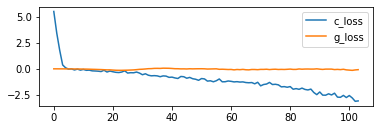

In [16]:
Base_WGAN.plot_history(train_metrics)

In [17]:
import json
with open(os.path.join('/content/drive/MyDrive/CS490/models/WGAN_projection2022.01.27-14:14:48/epoch_2', 'cm.txt')) as file:
  cm = json.load(file)

In [18]:
cm

[[1.0, 0.0, 1.0, 0.0, 0.0, 0.0],
 [11.0, 18.0, 6.0, 4.0, 6.0, 8.0],
 [0.0, 0.0, 0.0, 0.0, 1.0, 0.0],
 [6.0, 3.0, 8.0, 12.0, 5.0, 5.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 1.0, 0.0, 0.0, 1.0, 3.0]]